In [62]:
import os
import json
import glob
import pickle
import numpy as np
from Bio.PDB import *
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.Selection import unfold_entities
import multiprocessing as mp
import subprocess as sp

from scipy.stats import pearsonr
import seaborn as sb
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

three2one = {'ALA':'A','ARG':'R','ASN':'N','ASP':'D',
             'CYS':'C','GLN':'Q','GLU':'E','GLY':'G',
             'HIS':'H','ILE':'I','LEU':'L','LYS':'K',
             'MET':'M','PHE':'F','PRO':'P','SER':'S',
             'THR':'T','TRP':'W','TYR':'Y','VAL':'V',
             'MSE':'M'}

data = '/storage/af_analysis/'
originals = data+'/b4_original/'
bioinfotb = '/home/gabriele/Desktop/bioinfo-toolbox/'
dockq_path = '/home/gabriele/Desktop/programs/DockQ/DockQ.py'

codelist = [line.rstrip() for line in open(bioinfotb+'Alphafold2/benchmark4_files/list_dimers')]
with open(bioinfotb+'Alphafold2/benchmark4_files/hardness.pkl', 'rb') as f:
    hardness = pickle.load(f)
hard = hardness[0]
medium = hardness[1]
rigid = hardness[2]

docking_data = {
    'smallbfd_linker':{'path':data+'/b4_smallbfd_linker/'},
    'largebfd_linker':{'path':data+'/b4_largebfd_linker/'},
    'smallbfd_cutted':{'path':data+'/b4_smallbfd_cutted/'},
    'merged_arne':{'path':data+'/b4_merged_arne/'},
    'full_arne':{'path':data+'/b4_full_arne/'},
    }

linker_len = 50
int_thr = 8

pdbp = PDBParser(QUIET=True)

In [57]:
##### split models (joined or not by GLY linker)
for code in codelist:
    struct_orig = pdbp.get_structure('', originals+code+'_uc.pdb')
    res1 = unfold_entities(struct_orig[0]['A'], 'R')
    lastres1 = res1[-1].get_id()[1]
    lastresL = lastres1+linker_len
    
    for dockingset in docking_data:
        if 'linker' in dockingset: linker=True
        else: linker=False
        path = docking_data[dockingset]['path']+code
        dpath = path+'/ranked_0.pdb'
        if not os.path.exists(dpath): continue
        outfile = open(path+'/split_0.pdb', 'w')
        
        for line in open(dpath):
            if line.startswith('ATOM'):
                resnum = int(line[22:26].strip())
                if resnum <= lastres1: outfile.write(line)
                elif linker:
                    if resnum < lastresL: continue
                    elif resnum == lastresL and line[13:15] == 'N': outfile.write('TER\n')
                    elif resnum == lastresL: continue
                    else:
                        resnum -= lastresL
                        outfile.write(line[:21]+'B'+str(resnum).rjust(4)+line[26:])
                else:
                    if resnum == lastres1+201 and line[13:15] == 'N': outfile.write('TER\n')
                    resnum -= lastres1+200
                    outfile.write(line[:21]+'B'+str(resnum).rjust(4)+line[26:])

        outfile.write('TER\nEND')
        outfile.close()

In [58]:
##### Compute DockQ scores
def get_dockq(job):
    model = job[0]
    native = job[1]
    outpath = job[2]
    result = sp.run('python3 {} -short {} {}'.format(dockq_path, model, native), stdout=sp.PIPE, shell=True)
    print (model)
    return [result.stdout.decode('utf-8'), outpath]

joblist = []
for code in codelist:
    for dockingset in docking_data:
        path = docking_data[dockingset]['path']+code
        dpath = path+'/split_0.pdb'
        outpath = path+'/dockq_0'
        if not os.path.exists(dpath): continue
        if os.path.exists(outpath): continue
        joblist.append([dpath, originals+code+'_uc.pdb', outpath])

pool = mp.Pool(processes = 3)
results = pool.map(get_dockq, joblist)
pool.close()
pool.join()

for res in results:
    with open(res[1],'w') as outfile:
        outfile.write(res[0])    

/storage/af_analysis//b4_smallbfd_linker/1ay7/split_0.pdb
/storage/af_analysis//b4_smallbfd_linker/1he1/split_0.pdb
/storage/af_analysis//b4_full_arne/1pvh/split_0.pdb
/storage/af_analysis//b4_largebfd_linker/1ay7/split_0.pdb
/storage/af_analysis//b4_smallbfd_cutted/1he1/split_0.pdb
/storage/af_analysis//b4_smallbfd_linker/1qav/split_0.pdb
/storage/af_analysis//b4_smallbfd_cutted/1ay7/split_0.pdb
/storage/af_analysis//b4_smallbfd_cutted/1qav/split_0.pdb
/storage/af_analysis//b4_merged_arne/1he1/split_0.pdb
/storage/af_analysis//b4_merged_arne/1ay7/split_0.pdb
/storage/af_analysis//b4_merged_arne/1qav/split_0.pdb
/storage/af_analysis//b4_full_arne/1he1/split_0.pdb
/storage/af_analysis//b4_full_arne/1ay7/split_0.pdb
/storage/af_analysis//b4_full_arne/1qav/split_0.pdb
/storage/af_analysis//b4_smallbfd_linker/1b27/split_0.pdb
/storage/af_analysis//b4_smallbfd_linker/1r8s/split_0.pdb
/storage/af_analysis//b4_largebfd_linker/1b27/split_0.pdb
/storage/af_analysis//b4_smallbfd_linker/1i2m/spli

/storage/af_analysis//b4_smallbfd_linker/1fq1/split_0.pdb
/storage/af_analysis//b4_merged_arne/1wrd/split_0.pdb
/storage/af_analysis//b4_smallbfd_linker/1lb2/split_0.pdb
/storage/af_analysis//b4_full_arne/1wrd/split_0.pdb
/storage/af_analysis//b4_smallbfd_cutted/1fq1/split_0.pdb
/storage/af_analysis//b4_smallbfd_cutted/1lb2/split_0.pdb
/storage/af_analysis//b4_merged_arne/1fq1/split_0.pdb
/storage/af_analysis//b4_merged_arne/1lb2/split_0.pdb
/storage/af_analysis//b4_smallbfd_linker/1x86/split_0.pdb
/storage/af_analysis//b4_full_arne/1lb2/split_0.pdb
/storage/af_analysis//b4_full_arne/1fq1/split_0.pdb
/storage/af_analysis//b4_smallbfd_cutted/1x86/split_0.pdb
/storage/af_analysis//b4_smallbfd_linker/1lfd/split_0.pdb
/storage/af_analysis//b4_smallbfd_linker/1g6v/split_0.pdb
/storage/af_analysis//b4_largebfd_linker/1lfd/split_0.pdb
/storage/af_analysis//b4_merged_arne/1x86/split_0.pdb
/storage/af_analysis//b4_largebfd_linker/1g6v/split_0.pdb
/storage/af_analysis//b4_smallbfd_cutted/1lfd/sp

/storage/af_analysis//b4_smallbfd_cutted/2wbw/split_0.pdb
/storage/af_analysis//b4_largebfd_linker/2hrk/split_0.pdb
/storage/af_analysis//b4_merged_arne/2a9k/split_0.pdb
/storage/af_analysis//b4_merged_arne/2wbw/split_0.pdb
/storage/af_analysis//b4_smallbfd_cutted/2hrk/split_0.pdb
/storage/af_analysis//b4_full_arne/2a9k/split_0.pdb
/storage/af_analysis//b4_full_arne/2wbw/split_0.pdb
/storage/af_analysis//b4_merged_arne/2hrk/split_0.pdb
/storage/af_analysis//b4_smallbfd_linker/2abz/split_0.pdb
/storage/af_analysis//b4_full_arne/2hrk/split_0.pdb
/storage/af_analysis//b4_smallbfd_linker/2wy7/split_0.pdb
/storage/af_analysis//b4_largebfd_linker/2abz/split_0.pdb
/storage/af_analysis//b4_smallbfd_linker/2i25/split_0.pdb
/storage/af_analysis//b4_largebfd_linker/2wy7/split_0.pdb
/storage/af_analysis//b4_largebfd_linker/2i25/split_0.pdb
/storage/af_analysis//b4_smallbfd_cutted/2abz/split_0.pdb
/storage/af_analysis//b4_smallbfd_cutted/2wy7/split_0.pdb
/storage/af_analysis//b4_smallbfd_cutted/2i2

/storage/af_analysis//b4_full_arne/2c2v/split_0.pdb
/storage/af_analysis//b4_merged_arne/3bh6/split_0.pdb
/storage/af_analysis//b4_merged_arne/2uy7/split_0.pdb
/storage/af_analysis//b4_smallbfd_linker/2ch4/split_0.pdb
/storage/af_analysis//b4_full_arne/3bh6/split_0.pdb
/storage/af_analysis//b4_smallbfd_linker/3bs5/split_0.pdb
/storage/af_analysis//b4_smallbfd_linker/3cw2/split_0.pdb
/storage/af_analysis//b4_smallbfd_cutted/2ch4/split_0.pdb
/storage/af_analysis//b4_largebfd_linker/3bs5/split_0.pdb
/storage/af_analysis//b4_smallbfd_cutted/3bs5/split_0.pdb
/storage/af_analysis//b4_smallbfd_cutted/3cw2/split_0.pdb
/storage/af_analysis//b4_merged_arne/2ch4/split_0.pdb
/storage/af_analysis//b4_merged_arne/3bs5/split_0.pdb
/storage/af_analysis//b4_full_arne/3bs5/split_0.pdb
/storage/af_analysis//b4_merged_arne/3cw2/split_0.pdb
/storage/af_analysis//b4_full_arne/2ch4/split_0.pdb
/storage/af_analysis//b4_full_arne/3cw2/split_0.pdb
/storage/af_analysis//b4_smallbfd_linker/2d5r/split_0.pdb
/stora

/storage/af_analysis//b4_smallbfd_cutted/3ona/split_0.pdb
/storage/af_analysis//b4_merged_arne/3ona/split_0.pdb
/storage/af_analysis//b4_merged_arne/3znz/split_0.pdb
/storage/af_analysis//b4_smallbfd_cutted/3hzi/split_0.pdb
/storage/af_analysis//b4_full_arne/3ona/split_0.pdb
/storage/af_analysis//b4_full_arne/3znz/split_0.pdb
/storage/af_analysis//b4_merged_arne/3hzi/split_0.pdb
/storage/af_analysis//b4_smallbfd_linker/3ong/split_0.pdb
/storage/af_analysis//b4_smallbfd_linker/4bbn/split_0.pdb
/storage/af_analysis//b4_full_arne/3hzi/split_0.pdb
/storage/af_analysis//b4_largebfd_linker/3ong/split_0.pdb
/storage/af_analysis//b4_smallbfd_linker/3k1i/split_0.pdb
/storage/af_analysis//b4_smallbfd_cutted/3ong/split_0.pdb
/storage/af_analysis//b4_largebfd_linker/4bbn/split_0.pdb
/storage/af_analysis//b4_largebfd_linker/3k1i/split_0.pdb
/storage/af_analysis//b4_merged_arne/3ong/split_0.pdb
/storage/af_analysis//b4_smallbfd_cutted/3k1i/split_0.pdb
/storage/af_analysis//b4_full_arne/3ong/split_0.

/storage/af_analysis//b4_largebfd_linker/4hcn/split_0.pdb
/storage/af_analysis//b4_merged_arne/4mrt/split_0.pdb
/storage/af_analysis//b4_smallbfd_cutted/4etw/split_0.pdb
/storage/af_analysis//b4_smallbfd_cutted/4hcn/split_0.pdb
/storage/af_analysis//b4_full_arne/4mrt/split_0.pdb
/storage/af_analysis//b4_merged_arne/4etw/split_0.pdb
/storage/af_analysis//b4_merged_arne/4hcn/split_0.pdb
/storage/af_analysis//b4_full_arne/4etw/split_0.pdb
/storage/af_analysis//b4_smallbfd_linker/4n6o/split_0.pdb
/storage/af_analysis//b4_full_arne/4hcn/split_0.pdb
/storage/af_analysis//b4_smallbfd_linker/4f7g/split_0.pdb
/storage/af_analysis//b4_largebfd_linker/4n6o/split_0.pdb
/storage/af_analysis//b4_smallbfd_linker/4ilh/split_0.pdb
/storage/af_analysis//b4_smallbfd_cutted/4n6o/split_0.pdb
/storage/af_analysis//b4_largebfd_linker/4f7g/split_0.pdb
/storage/af_analysis//b4_merged_arne/4n6o/split_0.pdb
/storage/af_analysis//b4_smallbfd_cutted/4f7g/split_0.pdb
/storage/af_analysis//b4_largebfd_linker/4ilh/sp

/storage/af_analysis//b4_merged_arne/4llo/split_0.pdb
/storage/af_analysis//b4_largebfd_linker/4r62/split_0.pdb
/storage/af_analysis//b4_full_arne/4llo/split_0.pdb
/storage/af_analysis//b4_smallbfd_cutted/4yeb/split_0.pdb
/storage/af_analysis//b4_smallbfd_cutted/4r62/split_0.pdb
/storage/af_analysis//b4_merged_arne/4r62/split_0.pdb
/storage/af_analysis//b4_merged_arne/4yeb/split_0.pdb
/storage/af_analysis//b4_full_arne/4r62/split_0.pdb
/storage/af_analysis//b4_smallbfd_linker/4lsx/split_0.pdb
/storage/af_analysis//b4_full_arne/4yeb/split_0.pdb
/storage/af_analysis//b4_smallbfd_linker/4rf0/split_0.pdb
/storage/af_analysis//b4_smallbfd_linker/4zfr/split_0.pdb
/storage/af_analysis//b4_smallbfd_linker/4lx0/split_0.pdb
/storage/af_analysis//b4_largebfd_linker/4rf0/split_0.pdb
/storage/af_analysis//b4_largebfd_linker/4zfr/split_0.pdb
/storage/af_analysis//b4_smallbfd_cutted/4rf0/split_0.pdb
/storage/af_analysis//b4_smallbfd_cutted/4zfr/split_0.pdb
/storage/af_analysis//b4_smallbfd_cutted/4lx

In [63]:
##### load available DockQ scores
for dockingset in docking_data:
    dockqs = {}
    for code in codelist:
        path = docking_data[dockingset]['path']+code+'/dockq_0'
        if os.path.exists(path):
            line = open(path).readline()
            try:dockqs[code] = float(line.split()[1])
            except: print (line)
    docking_data[dockingset]['dockq'] = dockqs

In [37]:
real_cmaps = {}
for code in codelist:
    print (code)
    real_cmaps[code] = {}
    
    struct_orig = pdbp.get_structure('', originals+code+'_uc.pdb')
    resA = unfold_entities(struct_orig[0]['A'], 'R')
    resB = unfold_entities(struct_orig[0]['B'], 'R')
    linkerdimer = resA+linker_len*[None]+resB
    dimer = resA+resB
    
##### get real dimer contact-maps
    real_distances = np.ones((len(dimer), len(dimer), 1))*100
    real_distances_linker = np.ones((len(linkerdimer), len(linkerdimer), 1))*100
    for i, res1 in enumerate(dimer):
        for j, res2 in enumerate(dimer):
            if i <= j: continue
            elif res1 == None or res2 == None: continue
            elif 'CA' not in res1 or 'CA' not in res2: continue
            else: distance = res1['CA']-res2['CA']
                
            real_distances[i, j] = distance
            real_distances[j, i] = distance
            
            if j >= len(resA):
                real_distances_linker[i+linker_len, j+linker_len] = distance
                real_distances_linker[j+linker_len, i+linker_len] = distance
            elif i >= len(resA):
                real_distances_linker[i+linker_len, j] = distance
                real_distances_linker[j, i+linker_len] = distance
            else: 
                real_distances_linker[i, j] = distance
                real_distances_linker[j, i] = distance

    real_cmaps[code] = {'cmap':real_distances,
                        'cmap_linker':real_distances_linker}
    
##### get plDDTs, interface plDDTs and distograms
    docking_data[dockingset]['plddt'] = {}
    docking_data[dockingset]['int_plddt'] = {}
    docking_data[dockingset]['distogram'] = {}
    docking_data[dockingset]['distogram_bins'] = {}
    for dockingset in docking_data:
        path = docking_data[dockingset]['path']+code+'/result_model_1.pkl'
        if not os.path.exists(path): continue
        with open(path, 'rb') as p: model_feats = pickle.load(p)
        
        lddts = model_feats['plddt']
        if len(lddts) == len(dimer):
            
            docking_data[dockingset]['plddt'][code] = model_feats['plddt']
            
            real_distances[:len(resA),:len(resA)] = 100.
            real_distances[len(resA):,len(resA):] = 100.
            real_distances = real_distances.reshape(len(lddts), -1)
            docking_data[dockingset]['int_plddt'][code] =\
                np.where(np.any(real_distances<=int_thr, axis=-1), lddts, np.ones(lddts.shape)*-1)
        elif len(lddts) == len(linkerdimer):
            
            docking_data[dockingset]['plddt'][code] = \
                model_feats['plddt'][:len(resA)] + model_feats['plddt'][len(resA)+linker_len]
            
            real_distances_linker[:len(resA),:len(resA)] = 100.
            real_distances_linker[len(resA)+linker_len:,len(resA)+linker_len:] = 100.
            real_distances_linker = real_distances_linker.reshape(len(lddts), -1)
            docking_data[dockingset]['int_plddt'][code] =\
               np.where(np.any(real_distances_linker<=int_thr, axis=-1), lddts, np.ones(lddts.shape)*-1)
            
        docking_data[dockingset]['distogram'][code] = model_feats['distogram']['logits']
        docking_data[dockingset]['distogram_bins'][code] = model_feats['distogram']['bin_edges']

1ay7
1b27
1bdj
1buh
1bvn
1cc0
1clv
1dfj
1eay
1eer
1ewy
1fle
1fq1
1g6v
1g73
1gcq
1gg2
1gpw
1he1
1i2m
1i4e
1i8l
1ib1
1jiw
1jk9
1jtd
1k5g
1kgy
1lb2
1lfd
1mq8
1nbf
1nql
1nw9
1oc0
1pvh
1qav
1r8s
1s1q
1te1
1tmq
1uad
1uug
1v5i
1vg0
1vrs
1wq1
1wrd
1x86
1xt9
1y64
1y8x
1ycs
1yu6
1yvb
1z5y
1zlh
2a41
2a5d
2a9k
2abz
2aq3
2b4s
2bcg
2bcn
2bku
2bov
2bwe
2c0l
2c2v
2ch4
2d5r
2ejf
2g45
2grx
2gwf
2hj9
2hqs
2hrk
2i25
2ido
2iwt
2nqd
2nxn
2o25
2o2v
2o8v
2oob
2qyi
2sge
2uy7
2v55
2vdb
2vrr
2wbw
2wy7
2wy8
2x0b
2x9a
2xgy
2xwb
2zae
3a1p
3a8i
3av0
3bh6
3bs5
3buz
3bx1
3cbk
3cu1
3cw2
3d3c
3d5r
3daw
3e2l
3f1p
3f7p
3fap
3fn1
3fpu
3g3a
3hzi
3k1i
3k9m
3kld
3l1z
3l4q
3lb8
3lwn
3m18
3mj7
3mzw
3oed
3oj4
3ona
3ong
3onl
3oun
3pro
3prp
3pv6
3qc8
3qlu
3rj3
3rnk
3t5g
3tg1
3ulq
3vlb
3w31
3wkt
3znz
4bbn
4bi8
4bmp
4bos
4boz
4c0o
4c6t
4cpa
4ct4
4emj
4etw
4f7g
4fme
4ged
4gmj
4goj
4hcn
4ilh
4j38
4j4l
4jhp
4jqw
4jx1
4k0v
4kyi
4l41
4llo
4lsx
4lx0
4m3k
4mdk
4ml7
4mrt
4n6o
4nyi
4nzl
4o4b
4ol0
4p2a
4p4q
4pj2
4pou
4pw9
4r62
4rf0
4rix
4rws


Text(0, 0.5, 'SuccessRate(%)')

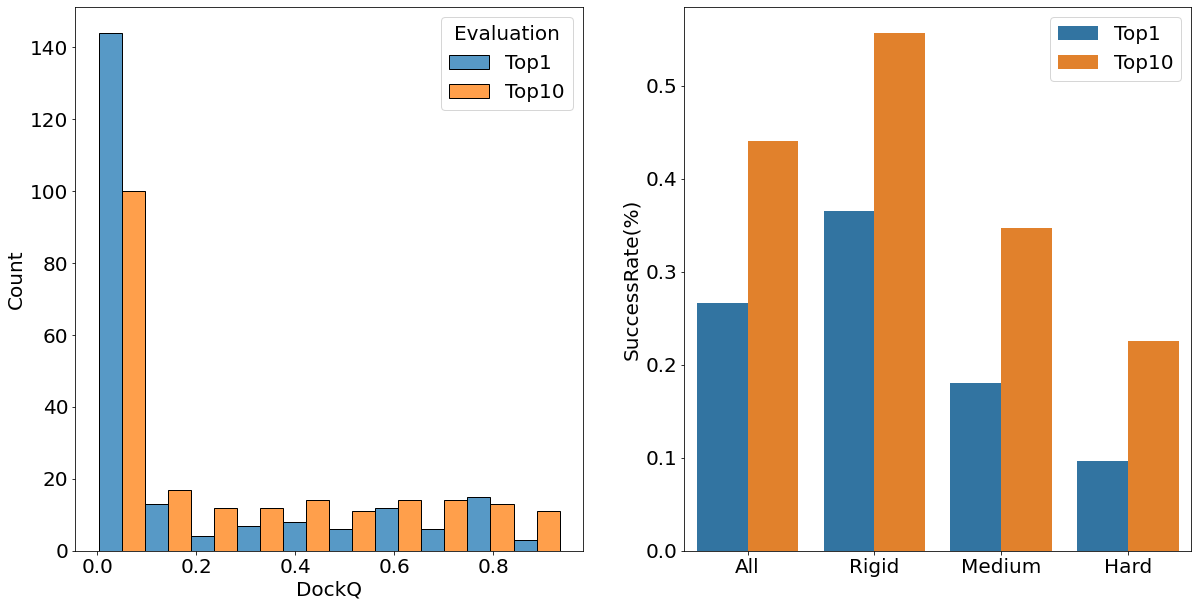

In [81]:
##### Plot DockQ distributions --- to fix
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

overall = [0,0,0,0,0,0,0,0]
succ = [0,0,0,0,0,0,0,0]
labels = ['All', 'All', 'Rigid', 'Rigid', 
          'Medium', 'Medium', 'Hard', 'Hard']
evaluation = ['Top1', 'Top10', 'Top1', 'Top10',
              'Top1', 'Top10', 'Top1', 'Top10']
dic = {'DockQ':[], 'Evaluation':[]}
for code in codelist:
    if len(dockqs[code]) == 0: continue
    dic['DockQ'].append(dockqs[code][0])
    dic['Evaluation'].append('Top1')
    dic['DockQ'].append(max(dockqs[code]))
    dic['Evaluation'].append('Top10')
    
    if dockqs[code][0] >= 0.23:
        succ[0] += 1
        if code in rigid: succ[2] += 1
        if code in medium: succ[4] += 1
        if code in hard: succ[6] += 1
    overall[0] += 1
    if code in rigid: overall[2] += 1
    if code in medium: overall[4] += 1
    if code in hard: overall[6] += 1
        
    if max(dockqs[code]) >= 0.23:
        succ[1] += 1
        if code in rigid: succ[3] += 1
        if code in medium: succ[5] += 1
        if code in hard: succ[7] += 1 
    overall[1] += 1
    if code in rigid: overall[3] += 1
    if code in medium: overall[5] += 1
    if code in hard: overall[7] += 1
        
succ[0] /= overall[0]
succ[1] /= overall[1]
succ[2] /= overall[2]
succ[3] /= overall[3]
succ[4] /= overall[4]
succ[5] /= overall[5]
succ[6] /= overall[6]
succ[7] /= overall[7]

sb.histplot(x='DockQ', hue='Evaluation', data=dic, multiple='dodge', ax=axes[0])
sb.barplot(x=labels, y=succ, hue=evaluation, ax=axes[1])
axes[1].set_ylabel('SuccessRate(%)')


[0.855, 0.9, 0.867, 0.883, 0.887, 0.333, 0.334, 0.329, 0.33, 0.329] [0.6474553833908413, 0.6387561418836986, 0.6517998105818357, 0.644948396186006, 0.6377719921064866, 0.6474553833908413, 0.6387561418836986, 0.6517998105818357, 0.644948396186006, 0.6377719921064866]
[0.58, 0.489, 0.705, 0.603, 0.734, 0.297, 0.31, 0.311, 0.31, 0.319] [0.6496177202567051, 0.6451817513120353, 0.6597485138459455, 0.6460040068075299, 0.6618262467869819, 0.6496177202567051, 0.6451817513120353, 0.6597485138459455, 0.6460040068075299, 0.6618262467869819]
[0.035, 0.036, 0.035, 0.038, 0.011, 0.034, 0.033, 0.037, 0.035, 0.033] [0.6247692053254713, 0.5947346799170843, 0.6276791306943059, 0.5924911083735304, 0.6394717085764428, 0.6247692053254713, 0.5947346799170843, 0.6276791306943059, 0.5924911083735304, 0.6394717085764428]
[0.013, 0.014, 0.015, 0.015, 0.014, 0.011, 0.011, 0.011, 0.015, 0.015] [0.604361239708703, 0.5828188931119399, 0.572114218331363, 0.5700945629786481, 0.5582050580003294, 0.604361239708703, 0.5

ValueError: x and y must have length at least 2.

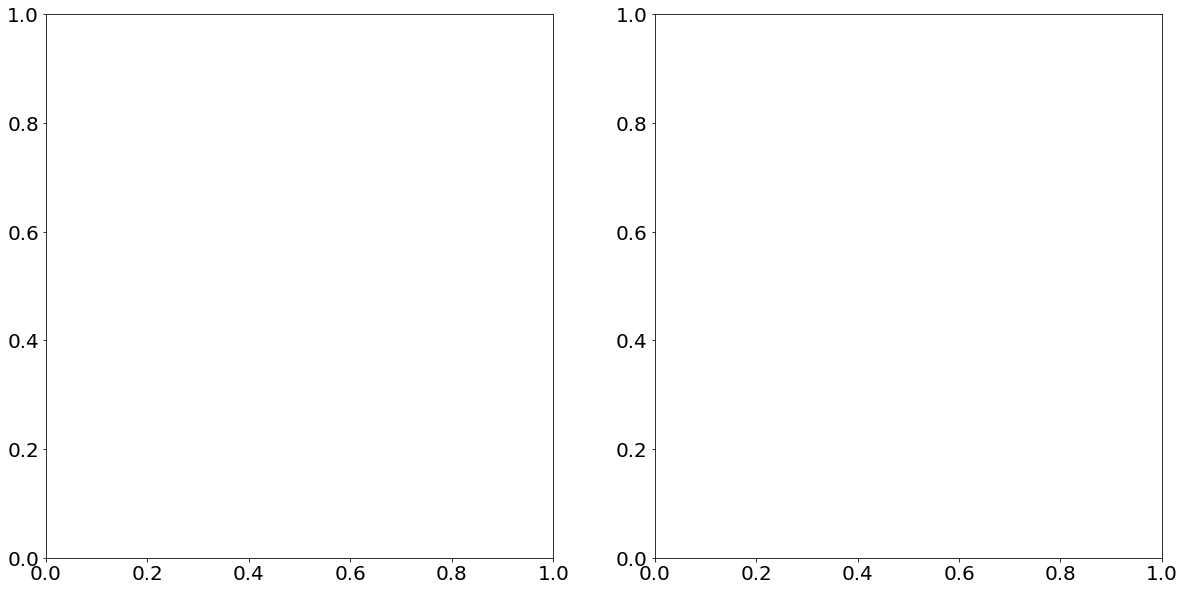

In [86]:
##### interface residues pLDDT correlation to DockQ score --- to fix
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

dic = {}
correlations = []
for code in codelist:
    code_int_quality = [int_qualities[code+'_f'][key] for key in int_qualities[code+'_f']]\
                      +[int_qualities[code+'_f'][key] for key in int_qualities[code+'_f']]

    print (dockqs[code], code_int_quality)
    pcc = pearsonr(dockqs[code], code_int_quality)
    correlations.append(pcc)
    
print (correlations)

sb.histplot(x=correlations, multiple='dodge', ax=axes[1])
    

In [ ]:
##### plot distogram --- to fix

for code in codelist:
    print (code)
    
    struct_orig = pdbp.get_structure('', originals+code+'_uc.pdb')
    resA = unfold_entities(struct_orig[0]['A'], 'R')
    resB = unfold_entities(struct_orig[0]['B'], 'R')
    dimer = resA+linker_len*[None]+resB
    
    real_distances_f = np.zeros((len(dimer), len(dimer), 1))
    for i, res1 in enumerate(dimer):
        for j, res2 in enumerate(dimer):
            if i <= j: continue
            if res1 == None or res2 == None: distance == 30
            else: distance = res1['CA']-res2['CA']
            real_distances_f[i,j] = distance
    real_distances_r = np.flipud(np.fliplr(real_distances_f))
    
    for order in ['f', 'r']:
        fpath = dockings + code + '_' + order
        
        if order == 'f':
            lastres1 = resA[-1].get_id()[1]
        else: 
            lastres1 = resB[-1].get_id()[1]
        firstres2 = lastres1+51
        
        for n in range(1,6):
            dpath = fpath + '/result_model_'+str(n)+'.pkl'
            if not os.path.exists: continue
            with open(dpath, 'rb') as p:
                model_feats = pickle.load(p)
            
            bins = model_feats['distogram']['bin_edges']
            distogram = model_feats['distogram']['logits']
            distogram[:,:,-2] = distogram[:,:,-2]+distogram[:,:,-1]
            distogram = distogram[:,:,:-1]
            #distogram = distogram - np.min(distogram, axis=-1)[:,:,None]
            distogram = np.where(distogram>=0, distogram, np.zeros(distogram.shape))
            distogram = (distogram/np.sum(distogram, axis=-1)[:,:,None])
            distogram = np.sum(distogram*bins, axis=-1)
        
for i in range(len(dimer)):
    for j in range(len(dimer)):
        if i <= j: continue
        distogram[i,j] = real_distances[i,j]
        
transp = 0.4
fig, axes = plt.subplots(1, 1, figsize=(20, 10), sharey=True)
cax = axes.matshow(distogram, cmap="hot")
x1=[0,len(distogram)]
y1=[lastres1,lastres1]
y2=[firstres2,firstres2]
x2=[lastres1,firstres2]
y3=[0,0]
y4=[len(distogram),len(distogram)]
axes.plot(x1, y1, lw=1, c="b", alpha=transp)
axes.plot(x1, y2, lw=1, c="b", alpha=transp)
axes.fill_between(x1, y1, y2, color="b", alpha=transp)

axes.plot(y1, x1, lw=1, c="b", alpha=transp)
axes.plot(y2, x1, lw=1, c="b", alpha=transp)
axes.fill_between(x2, y3, y4, color="b", alpha=transp)

        